In [1]:
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Store Data Variables
import json
with open('feature_data.json', 'r') as f:
 features = json.load(f)

from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
labels = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()
filelist = loadmat('cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
camId = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

In [9]:

X = np.array(features)
y = np.array(labels)
filelist = np.array(filelist)
camId = np.array(camId)



In [10]:
mask_train = np.array(train_idxs).ravel()
mask_query = np.array(query_idxs).ravel()
mask_gallery = np.array(gallery_idxs).ravel()

mask_train = np.subtract(mask_train, 1)
mask_query = np.subtract(mask_query, 1)
mask_gallery = np.subtract(mask_gallery, 1)


X_train, X_query, X_gallery = X[mask_train, :], X[mask_query, :], X[mask_gallery, :]
y_train, y_query, y_gallery = y[mask_train], y[mask_query], y[mask_gallery]
filelist_train, filelist_query, filelist_gallery = filelist[mask_train], filelist[mask_query], filelist[mask_gallery]
camId_train, camId_query, camId_gallery = camId[mask_train], camId[mask_query], camId[mask_gallery]


In [11]:
def get_acc_score(y_valid, y_q, tot_label_occur):
    recall = 0
    true_positives = 0
    
    k = 0
    
    max_rank = 30
    
    rank_A = np.zeros(max_rank)
    AP_arr = np.zeros(11)
    
    while (recall < 1) or (k < max_rank):
        
        if (y_valid[k] == y_q):
            
            true_positives = true_positives + 1
            recall = true_positives/tot_label_occur
            precision = true_positives/(k+1)
            
            AP_arr[round((recall-0.05)*10)] = precision
            
            for n in range (k, max_rank):
                rank_A[n] = 1
            
        k = k+1
        
    max_precision = 0
    for i in range(10, -1, -1):
        max_precision = max(max_precision, AP_arr[i])
        AP_arr[i] = max_precision
    
    AP_ = AP_arr.sum()/11
    
    return AP_, rank_A

In [21]:
from scipy.spatial import distance
from sklearn.metrics import pairwise

def evaluate_metric(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, kernel = 'polynomial', parameters = None):

    rank_accuracies = []
    AP = []

    # Break condition for testing
    #q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if kernel == 'polynomial':
                    qq = pairwise.polynomial_kernel(query.reshape(1, -1), query.reshape(1, -1))[0][0]
                    qg = pairwise.polynomial_kernel(query.reshape(1, -1), gallery.reshape(1, -1))[0][0]
                    gg = pairwise.polynomial_kernel(gallery.reshape(1, -1), gallery.reshape(1, -1))[0][0]
                elif kernel == 'gaussian_rbf':
                    qq = pairwise.rbf_kernel(query.reshape(1, -1), query.reshape(1, -1))[0][0]
                    qg = pairwise.rbf_kernel(query.reshape(1, -1), gallery.reshape(1, -1))[0][0]
                    gg = pairwise.rbf_kernel(gallery.reshape(1, -1), gallery.reshape(1, -1))[0][0]
                elif kernel == 'sigmoid':
                    qq = pairwise.sigmoid_kernel(query.reshape(1, -1), query.reshape(1, -1))[0][0]
                    qg = pairwise.sigmoid_kernel(query.reshape(1, -1), gallery.reshape(1, -1))[0][0]
                    gg = pairwise.sigmoid_kernel(gallery.reshape(1, -1), gallery.reshape(1, -1))[0][0]
                elif kernel == 'chi2':
                    qq = (pairwise.chi2_kernel(query.reshape(1, -1), query.reshape(1, -1))[0][0])**-1
                    qg = (pairwise.chi2_kernel(query.reshape(1, -1), gallery.reshape(1, -1))[0][0])**-1
                    gg = (pairwise.chi2_kernel(gallery.reshape(1, -1), gallery.reshape(1, -1))[0][0])**-1
                elif kernel == 'mahalanobis':
                    dist = distance.mahalanobis(query, gallery, parameters)
                else:
                    raise NameError('Specified metric not supported')
                dist = qq - 2*qg + gg
                q_g_dists.append(dist)
                y_valid.append(y_g)
    
        tot_label_occur = y_valid.count(y_q)
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid = q_g_dists[_indexes], y_valid[_indexes]
    
        AP_, rank_A = get_acc_score(y_valid, y_q, tot_label_occur)
    
        AP.append(AP_)
        
        rank_accuracies.append(rank_A)
    
        #if q  > 5:
        #    break
        #q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [13]:
rank_accuracies_l = []
mAP_l = []
metric_l = []

In [14]:
# Polynomial Kernel
rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       kernel ='polynomial',
                                       parameters = None)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('Polynomial')


Accuracies by Rank:
Rank  1  = 46.50% 	 Rank  2  = 54.71% 	 Rank  3  = 58.93% 	 Rank  4  = 63.43% 	 Rank  5  = 66.64%
Rank  6  = 69.07% 	 Rank  7  = 70.64% 	 Rank  8  = 72.14% 	 Rank  9  = 73.36% 	 Rank  10  = 74.86%
Rank  11  = 75.86% 	 Rank  12  = 76.57% 	 Rank  13  = 76.93% 	 Rank  14  = 77.93% 	 Rank  15  = 78.79%
Rank  16  = 79.21% 	 Rank  17  = 79.64% 	 Rank  18  = 80.36% 	 Rank  19  = 81.43% 	 Rank  20  = 81.86%
Rank  21  = 82.36% 	 Rank  22  = 82.79% 	 Rank  23  = 83.00% 	 Rank  24  = 83.50% 	 Rank  25  = 83.79%
Rank  26  = 84.21% 	 Rank  27  = 84.43% 	 Rank  28  = 84.86% 	 Rank  29  = 85.21% 	 Rank  30  = 85.57%
mAP = 45.52%


In [15]:
# Gaussian RBF Kernel
rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       kernel ='gaussian_rbf',
                                       parameters = None)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('Gaussian RBF')

Accuracies by Rank:
Rank  1  = 47.00% 	 Rank  2  = 54.57% 	 Rank  3  = 59.64% 	 Rank  4  = 63.93% 	 Rank  5  = 66.86%
Rank  6  = 69.29% 	 Rank  7  = 71.14% 	 Rank  8  = 72.36% 	 Rank  9  = 73.71% 	 Rank  10  = 74.93%
Rank  11  = 75.86% 	 Rank  12  = 76.79% 	 Rank  13  = 77.71% 	 Rank  14  = 78.50% 	 Rank  15  = 79.07%
Rank  16  = 79.86% 	 Rank  17  = 80.64% 	 Rank  18  = 81.57% 	 Rank  19  = 82.29% 	 Rank  20  = 83.21%
Rank  21  = 83.50% 	 Rank  22  = 83.71% 	 Rank  23  = 84.00% 	 Rank  24  = 84.29% 	 Rank  25  = 84.79%
Rank  26  = 85.29% 	 Rank  27  = 85.64% 	 Rank  28  = 85.93% 	 Rank  29  = 86.07% 	 Rank  30  = 86.36%
mAP = 46.57%


In [16]:
# Sigmoid Kernel
rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       kernel ='sigmoid',
                                       parameters = None)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('Sigmoid')

Accuracies by Rank:
Rank  1  = 47.21% 	 Rank  2  = 54.50% 	 Rank  3  = 60.21% 	 Rank  4  = 64.21% 	 Rank  5  = 67.43%
Rank  6  = 69.71% 	 Rank  7  = 71.14% 	 Rank  8  = 72.50% 	 Rank  9  = 74.07% 	 Rank  10  = 75.07%
Rank  11  = 76.36% 	 Rank  12  = 77.07% 	 Rank  13  = 78.14% 	 Rank  14  = 78.71% 	 Rank  15  = 79.43%
Rank  16  = 80.36% 	 Rank  17  = 81.14% 	 Rank  18  = 82.29% 	 Rank  19  = 82.79% 	 Rank  20  = 83.21%
Rank  21  = 83.57% 	 Rank  22  = 84.07% 	 Rank  23  = 84.21% 	 Rank  24  = 84.50% 	 Rank  25  = 84.86%
Rank  26  = 85.00% 	 Rank  27  = 85.36% 	 Rank  28  = 85.71% 	 Rank  29  = 86.07% 	 Rank  30  = 86.21%
mAP = 47.11%


In [22]:
# Chi Square Kernel
rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       kernel ='chi2',
                                       parameters = None)

rank_accuracies_l.append(rank_accuracies)
mAP_l.append(mAP)
metric_l.append('Chi Square')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars


Accuracies by Rank:
Rank  1  = 0.00% 	 Rank  2  = 0.00% 	 Rank  3  = 0.00% 	 Rank  4  = 0.00% 	 Rank  5  = 0.00%
Rank  6  = 0.00% 	 Rank  7  = 0.00% 	 Rank  8  = 0.00% 	 Rank  9  = 0.00% 	 Rank  10  = 0.00%
Rank  11  = 0.00% 	 Rank  12  = 0.00% 	 Rank  13  = 0.00% 	 Rank  14  = 0.00% 	 Rank  15  = 0.00%
Rank  16  = 0.00% 	 Rank  17  = 0.00% 	 Rank  18  = 0.00% 	 Rank  19  = 0.00% 	 Rank  20  = 0.00%
Rank  21  = 0.00% 	 Rank  22  = 0.00% 	 Rank  23  = 0.00% 	 Rank  24  = 0.00% 	 Rank  25  = 0.00%
Rank  26  = 0.00% 	 Rank  27  = 0.00% 	 Rank  28  = 0.00% 	 Rank  29  = 0.00% 	 Rank  30  = 0.00%
mAP = 0.07%


In [18]:
# Obtained from other file


rank_accuracy_base = np.array([47.00, 54.57, 59.64, 63.93, 66.86, 69.29, 71.14, 72.36, 73.71, 74.93, 75.86, 76.79, 77.71, 78.50, 79.07, 79.86, 80.64, 81.57, 82.29, 83.21, 83.50, 83.71, 84.00, 84.29, 84.79, 85.29, 85.64, 85.93, 86.07, 86.36])



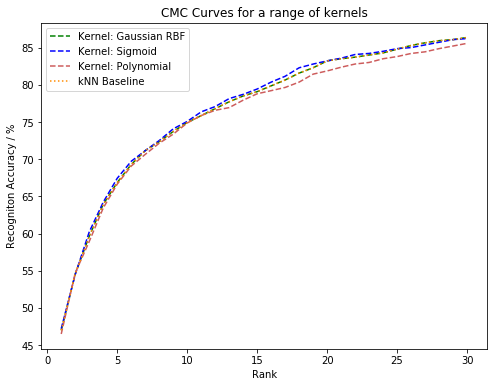

In [20]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(metric_l)-1):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l[i], color=color_list[i], linestyle='dashed', label='Kernel: '+ metric_l[i])
plt.plot(np.arange(1, 31), rank_accuracy_base, color='darkorange', linestyle=':', label='kNN Baseline')
plt.title('CMC Curves for a range of kernels')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')